### Step 5: Integrate Dynamic Intelligence 
Add a mini-net (e.g., 2-layer MLP) along the geodesic: At each t step, apply net to predict next grid state (e.g., rotation increment). Warping stabilizes the net’s output: M dampens noise in the ODE, ensuring convergence to correct without hardcoding.

Autoencoder Epoch 0: Loss = 0.0992
Autoencoder Epoch 20: Loss = 0.0683
Autoencoder Epoch 40: Loss = 0.0452
Autoencoder Epoch 60: Loss = 0.0303
Autoencoder Epoch 80: Loss = 0.0215
Autoencoder Epoch 100: Loss = 0.0209
Autoencoder Epoch 120: Loss = 0.0203
Autoencoder Epoch 140: Loss = 0.0207
Autoencoder Epoch 160: Loss = 0.0200
Autoencoder Epoch 180: Loss = 0.0198
MLP Epoch 0: Loss = 0.0266
MLP Epoch 20: Loss = 0.0008
MLP Epoch 40: Loss = 0.0003
MLP Epoch 60: Loss = 0.0001
MLP Epoch 80: Loss = 0.0001
MLP Epoch 100: Loss = 0.0000
MLP Epoch 120: Loss = 0.0000
MLP Epoch 140: Loss = 0.0000
MLP Epoch 160: Loss = 0.0000
MLP Epoch 180: Loss = 0.0000
Warped Manifold Converged to Target: True
Final Position (Well): [7.01702554 4.02390289 0.9987945  8.01197963 5.00187763 2.01282773
 9.01791534 6.01971295 3.01467444]
Target Position: [7. 4. 1. 8. 5. 2. 9. 6. 3.]


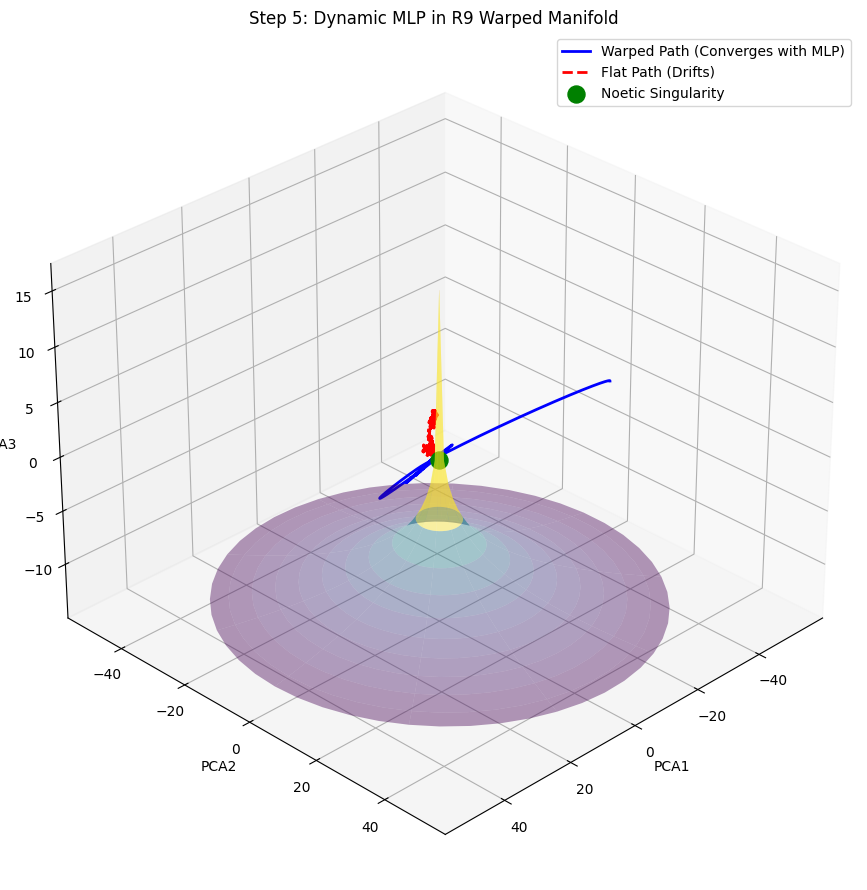

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim

# Custom PCA using NumPy (replaces sklearn)
def custom_pca(data, n_components=3):
    mean = np.mean(data, axis=0)
    data_centered = data - mean
    cov = np.cov(data_centered.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    projected = data_centered @ eigenvectors[:, :n_components]
    return projected

# Define 90° clockwise rotation matrix for R9 (permutation matrix)
R = np.zeros((9, 9), dtype=np.float32)
mapping = [6, 3, 0, 7, 4, 1, 8, 5, 2]  # Indices for rotated positions
for new_idx, old_idx in enumerate(mapping):
    R[new_idx, old_idx] = 1

# Generate structured synthetic data for autoencoder and MLP
def generate_structured_data(num_samples=1000):
    data = []
    for _ in range(num_samples // 4):
        base = np.random.randint(0, 10, size=9).astype(np.float32)
        data.append(base)
        rot1 = (R @ base)
        data.append(rot1)
        rot2 = (R @ rot1)
        data.append(rot2)
        rot3 = (R @ rot2)
        data.append(rot3)
    return np.array(data)

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(9, 32), nn.ReLU(), nn.Linear(32, 9), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(9, 32), nn.ReLU(), nn.Linear(32, 9), nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def train_autoencoder(data, epochs=200, lr=0.01):
    data_norm = (data / 9.0).astype(np.float32)
    data_tensor = torch.tensor(data_norm, dtype=torch.float32)
    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        _, decoded = model(data_tensor)
        loss = criterion(decoded, data_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f"Autoencoder Epoch {epoch}: Loss = {loss.item():.4f}")
    return model

# Mini-Net: 2-layer MLP for predicting rotation increment
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(nn.Linear(9, 32), nn.ReLU(), nn.Linear(32, 9))

    def forward(self, x):
        return self.layers(x)

def train_mlp(data, epochs=200, lr=0.01, increment_strength=0.005):
    data_norm = (data / 9.0).astype(np.float32)
    data_tensor = torch.tensor(data_norm, dtype=torch.float32)
    deltas = []
    for x in data:
        delta = increment_strength * ((R @ x) - x)
        deltas.append(delta)
    deltas = np.array(deltas, dtype=np.float32)
    deltas_norm = (deltas / 9.0).astype(np.float32)
    deltas_tensor = torch.tensor(deltas_norm, dtype=torch.float32)
    model = MLP()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        predicted_deltas = model(data_tensor)
        loss = criterion(predicted_deltas, deltas_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f"MLP Epoch {epoch}: Loss = {loss.item():.4f}")
    return model

# Geodesic equations with dynamic MLP increment
def geodesic_eqs(y, t, M, r_scale, target, gamma, mlp, rotation_strength):
    x = y[:9]
    dx = y[9:]
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))
    factor = 1 - 2 * M_eff / r
    # Convert x to torch for MLP inference
    x_norm = (x / 9.0).astype(np.float32)
    x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0)
    delta = mlp(x_tensor).detach().numpy().squeeze() * 9.0
    # Acceleration: Warping + learned rotation increment + pull + damping
    d2x = -M_eff * x / r**3 * factor + rotation_strength * delta + 0.3 * M_eff * (target - x) / (np.linalg.norm(target - x) + 1e-6) - gamma * dx
    return np.concatenate([dx, d2x])

# Parameters
M = 15.0
r_scale = 15.0
gamma = 0.1
rotation_strength = 0.005
t = np.linspace(0, 100, 2000)

# Generate data, train models
data = generate_structured_data()
autoencoder = train_autoencoder(data)
mlp = train_mlp(data)

# Input and target
input_r9 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.float32)
target_r9 = (R @ input_r9).astype(np.float32)

# Embed input
input_tensor = torch.tensor(input_r9 / 9.0, dtype=torch.float32).unsqueeze(0)
embedded_input, _ = autoencoder(input_tensor)
embedded_input = embedded_input.detach().numpy().squeeze() * 9.0
embedded_target = target_r9  # For simplicity

# Initial conditions
y0 = np.concatenate([embedded_input, np.full(9, 0.05)])

# Solve warped path with MLP
sol_well = odeint(geodesic_eqs, y0, t, args=(M, r_scale, embedded_target, gamma, mlp, rotation_strength))
x_well_r9 = sol_well[:, :9]
x_well_r3 = custom_pca(x_well_r9)

# Flat space (no M, no MLP, no pull)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, embedded_target, gamma, mlp, 0))  # rotation_strength=0
x_flat_r9 = sol_flat[:, :9]
x_flat_r3 = custom_pca(x_flat_r9)
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))
x_flat_r3 += np.cumsum(noise, axis=0)

# Check convergence
final_pos_well = x_well_r9[-1]
converged = np.all(np.abs(final_pos_well - embedded_target) < 0.1)
print(f"Warped Manifold Converged to Target: {converged}")
print(f"Final Position (Well): {final_pos_well}")
print(f"Target Position: {embedded_target}")

# Funnel surface (k=50.0)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = -50.0 * np.log(V + 1e-6) / (M + 1e-6)

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)
ax.plot(x_well_r3[:, 0], x_well_r3[:, 1], x_well_r3[:, 2], 'b-', linewidth=2, label='Warped Path (Converges with MLP)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', linewidth=2, label='Flat Path (Drifts)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Step 5: Dynamic MLP in R9 Warped Manifold')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('step5_simulation.png')
plt.show()